In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import dask
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
path='../../Data/ds_zeppelin_2010_2019.nc'
ds = xr.open_dataset(path)

In [3]:
len(ds.time_traj.values)


96

In [4]:
ds

<xarray.Dataset>
Dimensions:            (D: 33, time: 53132, time_traj: 96)
Coordinates:
  * D                  (D) float64 10.0 11.22 12.59 14.12 ... 316.2 354.8 398.1
  * time               (time) datetime64[ns] 2010-08-03 ... 2019-12-31T23:00:00
  * time_traj          (time_traj) int64 0 1 2 3 4 5 6 ... 89 90 91 92 93 94 95
Data variables:
    pnsd               (time, D) float64 ...
    pnsd_nolog         (time, D) float64 ...
    conc_10_50         (time) float64 ...
    conc_50_100        (time) float64 ...
    conc_100_400       (time) float64 ...
    condensation_sink  (time) float64 ...
    Rainfall           (time, time_traj) float64 ...
    Solar_radiation    (time, time_traj) float64 ...
    x                  (time, time_traj) float64 ...
    y                  (time, time_traj) float64 ...
    z                  (time, time_traj) float64 ...

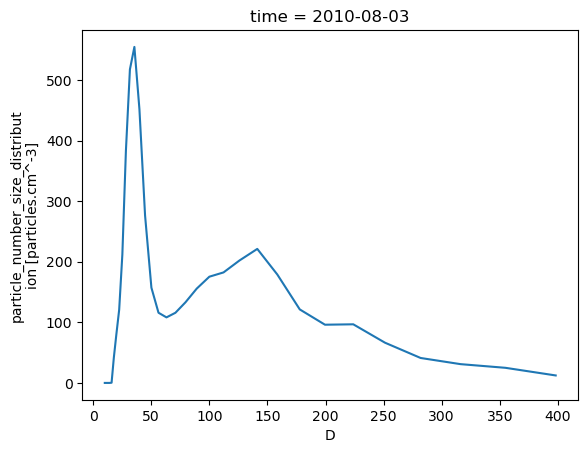

In [5]:
dist_1 = ds['pnsd'].isel(time=0)
dist_1.plot()

def plot_dist(variable, t): # function for plotting number size distribution for a given time
    dist = ds[variable].isel(time=t)
    dist.plot()

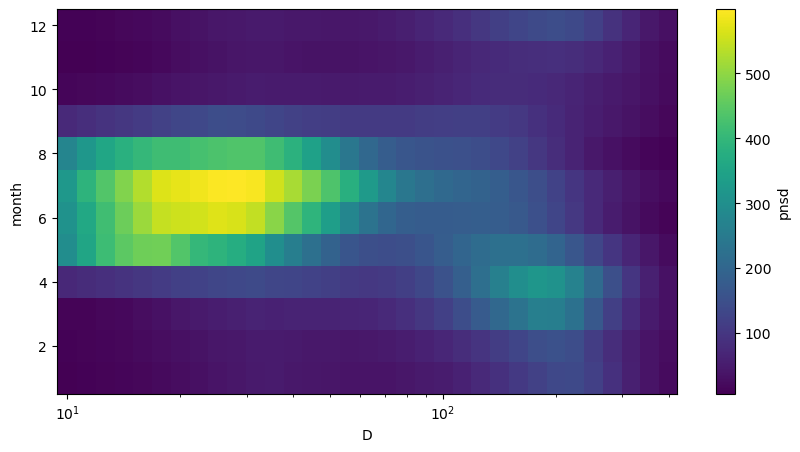

In [6]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
month_mean = ds['pnsd'].groupby(ds.time.dt.month).mean()
month_mean.plot()
ax.set_xscale('log')

In [7]:
ds_season = ds.groupby('time.season').mean(keep_attrs=True)

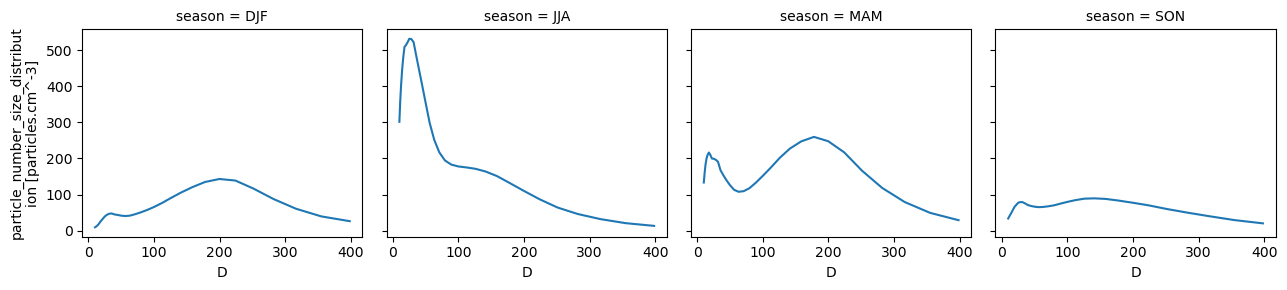

In [8]:
ds_season['pnsd'].plot(col='season')

In [9]:
# Making a dataframe
df = pd.DataFrame(ds.pnsd.values, ds.time, ds.D)
df.head()

,10.000,11.220,12.589,14.125,15.849,17.783,19.953,22.387,25.119,28.184,...,141.254,158.489,177.828,199.526,223.872,251.189,281.838,316.228,354.813,398.107
2010-08-03 00:00:00,2.790497e-29,2.786005e-29,2.780935e-29,2.774283e-29,0.329741,41.606174,80.042240,120.892820,211.96954,383.428990,...,221.209820,178.977250,121.321720,96.090906,96.753904,66.386077,41.174992,30.989534,24.949570,12.333647
2010-08-03 01:00:00,2.789934e-29,2.785442e-29,2.779898e-29,2.528172e+00,12.974548,46.179508,141.295206,261.746105,315.75037,418.689125,...,85.695794,77.510495,77.746907,73.046753,50.889920,36.805352,25.441112,16.356454,11.408104,6.106511
2010-08-03 02:00:00,2.788325e-29,2.783747e-29,8.622146e+00,2.673972e+01,58.898629,100.978881,114.139330,141.574896,240.53080,327.122450,...,59.707636,53.033274,55.894537,52.390985,28.318534,19.184356,13.502628,8.935019,2.800536,3.287963
2010-08-03 03:00:00,2.787113e-29,2.782619e-29,2.777548e-29,2.770892e-29,1.415207,145.340800,148.781480,138.566340,246.65246,296.561560,...,182.845500,124.763920,133.017030,133.790430,64.798919,59.888534,43.716792,15.603318,16.124321,12.564497
2010-08-08 19:00:00,2.785696e-29,2.781117e-29,8.601954e+00,4.934555e+01,128.736955,210.290670,287.625065,334.561305,363.43000,358.072995,...,3.437324,1.959949,1.222223,0.898871,0.970009,0.691989,0.298961,0.005690,0.345479,0.783144


#### Finding the optimal k (number of clusters):

In [10]:
df.describe()

,10.000,11.220,12.589,14.125,15.849,17.783,19.953,22.387,25.119,28.184,...,141.254,158.489,177.828,199.526,223.872,251.189,281.838,316.228,354.813,398.107
count,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,...,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04
mean,1.250638e+02,1.472622e+02,1.675036e+02,1.845569e+02,1.990807e+02,2.114686e+02,2.140854e+02,2.160548e+02,2.213825e+02,2.219974e+02,...,1.472334e+02,1.517104e+02,1.516202e+02,1.430552e+02,1.262640e+02,9.999934e+01,7.439412e+01,5.223507e+01,3.426870e+01,2.194304e+01
std,6.559779e+02,7.108893e+02,7.028472e+02,7.210722e+02,7.349052e+02,7.400234e+02,7.077335e+02,6.792891e+02,6.761447e+02,6.485391e+02,...,1.596316e+02,1.647599e+02,1.706566e+02,1.655136e+02,1.519354e+02,1.212825e+02,9.291079e+01,7.105404e+01,5.386824e+01,3.972660e+01
min,2.129550e-29,2.126170e-29,2.121627e-29,2.122920e-29,2.121105e-29,2.114443e-29,2.109589e-29,2.099396e-29,2.092112e-29,1.982091e-29,...,1.682741e-29,1.647067e-29,1.604406e-29,1.563965e-29,1.526628e-29,1.413993e-29,1.389839e-29,1.355980e-29,1.316102e-29,1.286877e-29
25%,1.011319e+00,1.284413e+00,3.240118e+00,5.039511e+00,7.152786e+00,1.060955e+01,1.414256e+01,1.814460e+01,2.169366e+01,2.452544e+01,...,4.304729e+01,4.247675e+01,3.928606e+01,3.335857e+01,2.633891e+01,1.889800e+01,1.349613e+01,9.383922e+00,6.124410e+00,3.761472e+00
50%,7.016288e+00,9.152810e+00,1.202604e+01,1.529895e+01,1.998066e+01,2.637089e+01,3.356888e+01,4.181856e+01,4.991856e+01,5.667965e+01,...,1.000522e+02,1.022415e+02,9.911840e+01,9.116297e+01,7.651579e+01,5.862825e+01,4.269992e+01,2.910467e+01,1.822160e+01,1.135785e+01
75%,3.329264e+01,3.877631e+01,4.668340e+01,5.776853e+01,7.334384e+01,9.237277e+01,1.122379e+02,1.336096e+02,1.541469e+02,1.690156e+02,...,2.006485e+02,2.061194e+02,2.046654e+02,1.927744e+02,1.701851e+02,1.381617e+02,1.035013e+02,7.103348e+01,4.437893e+01,2.689547e+01
max,7.985327e+04,7.470496e+04,3.408616e+04,2.987265e+04,2.418635e+04,1.749829e+04,2.340646e+04,2.223558e+04,3.130832e+04,3.755233e+04,...,3.310102e+03,2.100256e+03,1.888381e+03,1.929025e+03,1.851297e+03,2.080121e+03,2.246036e+03,2.280511e+03,2.104574e+03,1.692586e+03


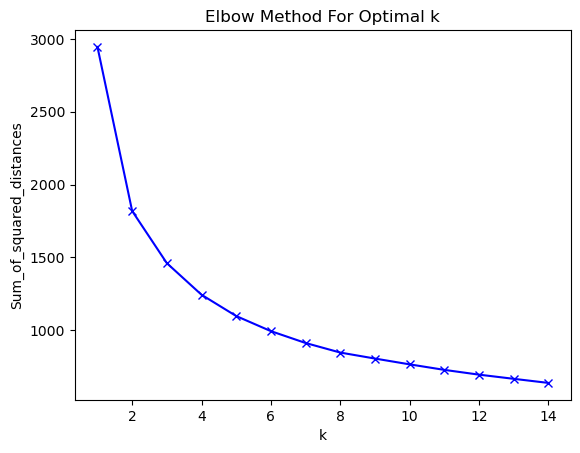

In [11]:
def k_elbow(df):
    mms = MinMaxScaler()
    mms.fit(df)
    data_transformed = mms.transform(df)
    
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data_transformed)
        Sum_of_squared_distances.append(km.inertia_)
        
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
k_elbow(df)

In [12]:
"""
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
"""

'\nSum_of_squared_distances = []\nK = range(1,15)\nfor k in K:\n    km = KMeans(n_clusters=k)\n    km = km.fit(data_transformed)\n    Sum_of_squared_distances.append(km.inertia_)\n'

In [13]:
"""
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
"""

"\nplt.plot(K, Sum_of_squared_distances, 'bx-')\nplt.xlabel('k')\nplt.ylabel('Sum_of_squared_distances')\nplt.title('Elbow Method For Optimal k')\nplt.show()\n"

The elbow is at k=5, indicating the optimal k for the particle number size is 5

### Clustering 

In [14]:
#Initialize the class object
kmeans = KMeans(n_clusters=5)

#predict the labels of clusters
label = kmeans.fit_predict(df)
label

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [15]:
df['cluster']=label
df.head()

,10.0,11.22,12.589,14.125,15.849,17.783,19.953,22.387,25.119,28.184,...,158.489,177.828,199.526,223.872,251.189,281.838,316.228,354.813,398.107,cluster
2010-08-03 00:00:00,2.790497e-29,2.786005e-29,2.780935e-29,2.774283e-29,0.329741,41.606174,80.042240,120.892820,211.96954,383.428990,...,178.977250,121.321720,96.090906,96.753904,66.386077,41.174992,30.989534,24.949570,12.333647,0
2010-08-03 01:00:00,2.789934e-29,2.785442e-29,2.779898e-29,2.528172e+00,12.974548,46.179508,141.295206,261.746105,315.75037,418.689125,...,77.510495,77.746907,73.046753,50.889920,36.805352,25.441112,16.356454,11.408104,6.106511,0
2010-08-03 02:00:00,2.788325e-29,2.783747e-29,8.622146e+00,2.673972e+01,58.898629,100.978881,114.139330,141.574896,240.53080,327.122450,...,53.033274,55.894537,52.390985,28.318534,19.184356,13.502628,8.935019,2.800536,3.287963,0
2010-08-03 03:00:00,2.787113e-29,2.782619e-29,2.777548e-29,2.770892e-29,1.415207,145.340800,148.781480,138.566340,246.65246,296.561560,...,124.763920,133.017030,133.790430,64.798919,59.888534,43.716792,15.603318,16.124321,12.564497,0
2010-08-08 19:00:00,2.785696e-29,2.781117e-29,8.601954e+00,4.934555e+01,128.736955,210.290670,287.625065,334.561305,363.43000,358.072995,...,1.959949,1.222223,0.898871,0.970009,0.691989,0.298961,0.005690,0.345479,0.783144,0


In [16]:
D = ds.D
g = df.groupby('cluster')
median_clust = g.median()
percentile75 = g.quantile(0.75)
percentile25 = g.quantile(0.25)



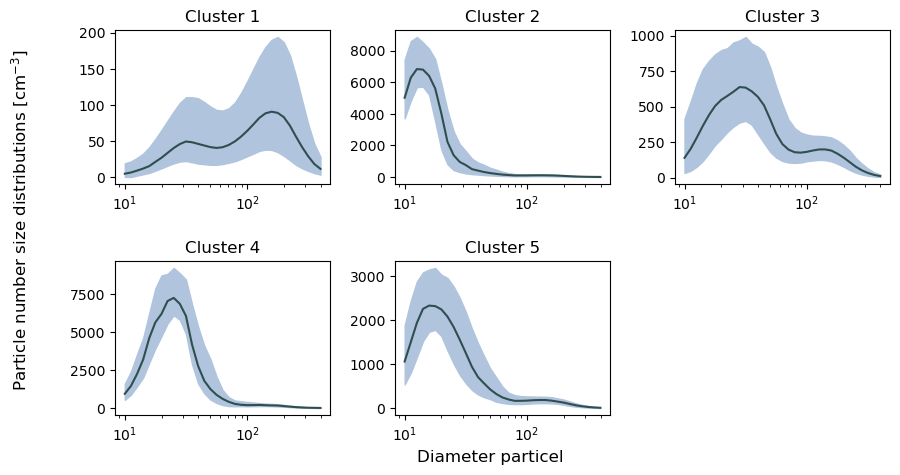

In [17]:

#def plot_cluster(median, percentile25, percentile75)
fig = plt.figure(figsize=(10,5))

for i in range(5):
    ax = fig.add_subplot(2, 3, i+1)
    ax.fill_between(D, percentile25.iloc[i], percentile75.iloc[i], color='lightsteelblue')
    ax.plot(D, median_clust.iloc[i], color='darkslategrey')
    ax.set_xscale('log')
    ax.set_title('Cluster '+str(i+1))
    

plt.subplots_adjust(wspace=0.3, hspace=0.5)
#fig.suptitle('Clusters', fontsize=16)
fig.supxlabel('Diameter particel')
fig.supylabel('Particle number size distributions [cm$^{-3}$]');

Could also maybe look at the normalized clusters^

### normalized cluster

In [18]:
df_norm = df.div(df.max(axis=1), axis=0)
df_norm.head()

,10.0,11.22,12.589,14.125,15.849,17.783,19.953,22.387,25.119,28.184,...,158.489,177.828,199.526,223.872,251.189,281.838,316.228,354.813,398.107,cluster
2010-08-03 00:00:00,5.031303e-32,5.023205e-32,5.014064e-32,5.002070e-32,0.000595,0.075016,0.144317,0.217971,0.382184,0.691328,...,0.322698,0.218745,0.173253,0.174449,0.119695,0.074239,0.055875,0.044984,0.022238,0.0
2010-08-03 01:00:00,4.872907e-32,4.865062e-32,4.855378e-32,4.415712e-03,0.022661,0.080657,0.246787,0.457167,0.551491,0.731284,...,0.135380,0.135793,0.127584,0.088884,0.064284,0.044436,0.028568,0.019925,0.010666,0.0
2010-08-03 02:00:00,6.567502e-32,6.556720e-32,2.030823e-02,6.298159e-02,0.138727,0.237841,0.268839,0.333459,0.566536,0.770490,...,0.124912,0.131652,0.123399,0.066700,0.045186,0.031804,0.021045,0.006596,0.007744,0.0
2010-08-03 03:00:00,4.371393e-32,4.364346e-32,4.356391e-32,4.345953e-32,0.002220,0.227957,0.233353,0.217332,0.386857,0.465136,...,0.195684,0.208628,0.209841,0.101633,0.093931,0.068567,0.024473,0.025290,0.019707,0.0
2010-08-08 19:00:00,7.665014e-32,7.652415e-32,2.366881e-02,1.357773e-01,0.354228,0.578628,0.791418,0.920566,1.000000,0.985260,...,0.005393,0.003363,0.002473,0.002669,0.001904,0.000823,0.000016,0.000951,0.002155,0.0


/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


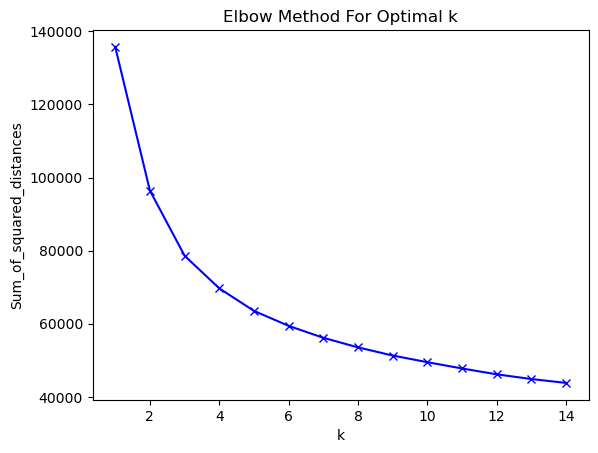

In [19]:
k_elbow(df_norm)

The elbow is at k=6, indicating the optimal k for the particle number size is 6

In [20]:
#Initialize the class object
kmeans = KMeans(n_clusters=5)

#predict the labels of clusters
label = kmeans.fit_predict(df_norm)
label

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([1, 1, 1, ..., 4, 4, 4], dtype=int32)

In [21]:
df_norm['cluster']=label

In [22]:
g = df_norm.groupby('cluster')
median_clust = g.median()
percentile75 = g.quantile(0.75)
percentile25 = g.quantile(0.25)

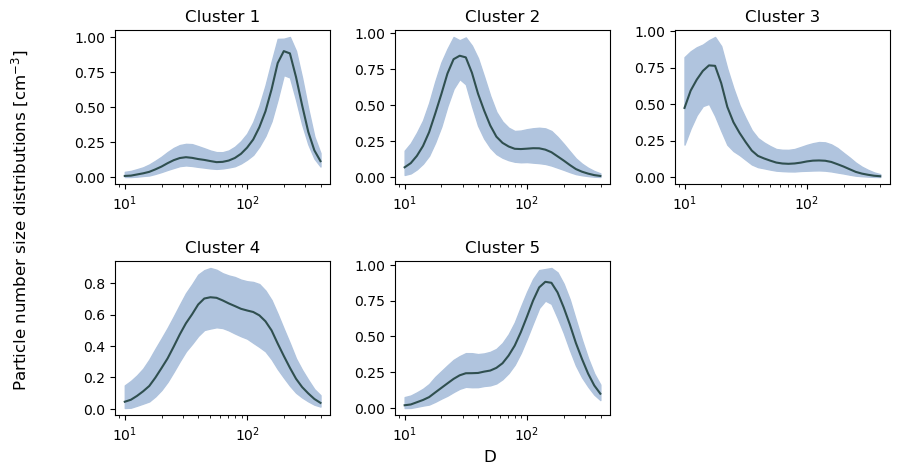

In [23]:
fig = plt.figure(figsize=(10,5))

for i in range(5):
    ax = fig.add_subplot(2, 3, i+1)
    ax.fill_between(D, percentile25.iloc[i], percentile75.iloc[i], color='lightsteelblue')
    ax.plot(D, median_clust.iloc[i], color='darkslategrey')
    ax.set_xscale('log')
    ax.set_title('Cluster '+str(i+1))
    

plt.subplots_adjust(wspace=0.3, hspace=0.5)
#fig.suptitle('Clusters', fontsize=16)
fig.supxlabel('D')
fig.supylabel('Particle number size distributions [cm$^{-3}$]');

#### Accumulated precipitation for each cluster

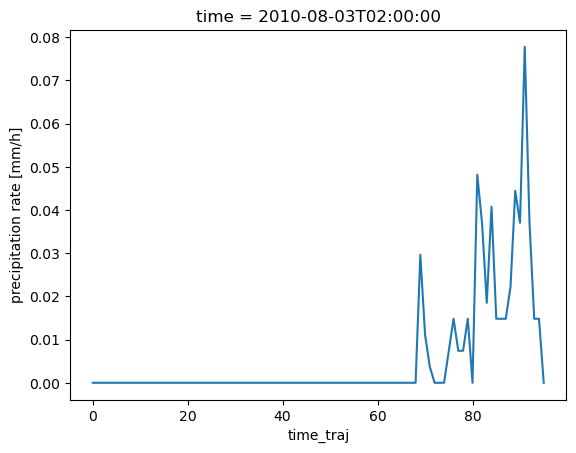

In [24]:
ds['Rainfall']
plot_dist('Rainfall', 2)

In [25]:
accum_rain = ds['Rainfall'].cumsum(axis=1)
ds['accum_rainfall'] = accum_rain

In [26]:
# Making a dataframe
df_rain = pd.DataFrame(ds.accum_rainfall.values, ds.time, ds.time_traj)
df_rain_norm = df_rain.div(df.max(axis=1), axis=0)
df_rain_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
2010-08-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000614,0.000614,0.000614,0.000614,0.000614,0.000614,0.000614,0.000614,0.000614,0.000614
2010-08-03 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000505,0.000524,0.000543,0.000543,0.000543,0.000569,0.000569,0.000569,0.000569,0.000569
2010-08-03 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000637,0.000672,0.000724,0.000829,0.000916,0.001099,0.001186,0.001221,0.001256,0.001256
2010-08-03 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000168,0.000250,0.000302,0.000319,0.000331,0.000401,0.000453,0.000529,0.000552,0.000587
2010-08-08 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002313,0.002374,0.002436,0.002639,0.002833,0.002976,0.003037,0.003139,0.003180,0.003200


In [27]:
df_rain_norm['cluster']=label
time_traj = ds.time_traj

In [28]:
g = df_rain_norm.groupby('cluster')
rain_median_clust = g.median()
rain_percentile75 = g.quantile(0.75)
rain_percentile25 = g.quantile(0.25)

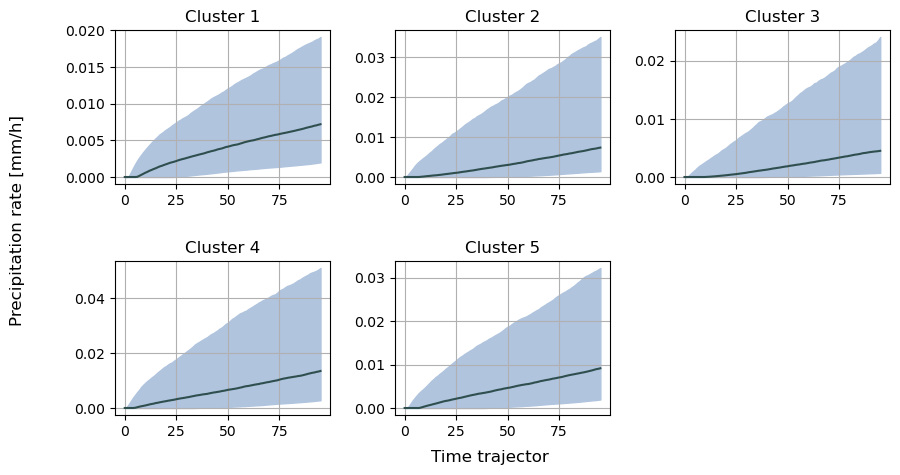

In [29]:
fig = plt.figure(figsize=(10,5))

for i in range(5):
    ax = fig.add_subplot(2, 3, i+1)
    ax.fill_between(time_traj, rain_percentile25.iloc[i], rain_percentile75.iloc[i], color='lightsteelblue')
    ax.plot(time_traj, rain_median_clust.iloc[i], color='darkslategrey')
    #ax.set_xscale('log')
    ax.set_title('Cluster '+str(i+1))
    plt.grid()
    

plt.subplots_adjust(wspace=0.3, hspace=0.5)
#fig.suptitle('Clusters', fontsize=16)
fig.supxlabel('Time trajector')
fig.supylabel('Precipitation rate [mm/h]');

### Trajector map

#### Things to do:

- first add accumulated rainfall to the dataset for 6, or 96 hours for example. Then make it into a dataframe and add the clusters. use groupby, and plot (make it into a function first)


- Make distrubutions that fit differents modes of the particle number size distribution. (Usally two modes (for small and larger))
- Plot clusters at each trajectory

- plot trends of precipitation and aerosols on a map


#### Model data


In [30]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [31]:
#print(col.df.variable_id.unique())

In [32]:
cat = col.search(source_id=['NorESM2-MM'], experiment_id=['ssp585'], table_id=['Amon', 'Emon'], variable_id=['tas', 'conccn', 'prc', 'pr', 'concnmcn', 'conccmcn'], member_id=['r1i1p1f1'])
#cat2 = col.search(source_id=['NorESM2-MM'], experiment_id=['ssp585'], table_id=['Emon'], variable_id=['conccn', 'concnmcn', 'conccmcn'])#, member_id=['r1i1p1f1'])

In [33]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
#dset_dict2 = cat2.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [34]:
dset = list(dset_dict.values())[0]
dset = dset.compute()

In [35]:
#dset2 = list(dset_dict2.values())[0]
#dset2

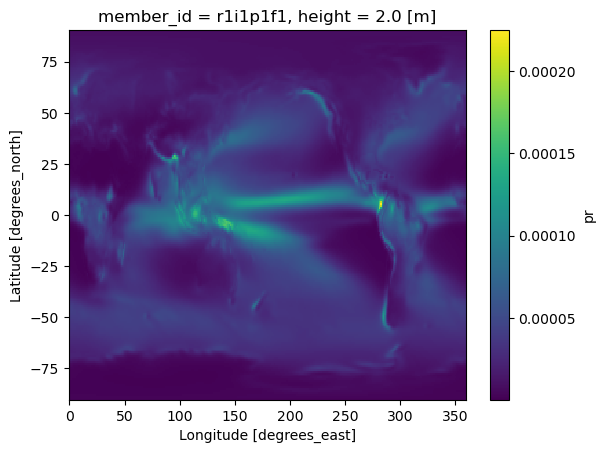

In [36]:
dset['pr'].mean('time').plot()

In [37]:
# decadal precipitation

NorESM_yearly = dset.resample(time="Y").mean()*86400 #mm/decades
NorESM_yearly

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, member_id: 1, time: 86)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    height     float64 2.0
    lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 ... 358.1 358.1 359.4
  * member_id  (member_id) <U8 'r1i1p1f1'
  * time       (time) object 2015-12-31 00:00:00 ... 2100-12-31 00:00:00
Dimensions without coordinates: bnds
Data variables:
    pr         (member_id, time, lat, lon) float64 0.2018 0.2018 ... 0.9593
    prc        (member_id, time, lat, lon) float64 0.0 0.0 ... 0.01395 0.01396
    tas        (member_id, time, lat, lon) float64 1.965e+07 ... 2.308e+07

In [40]:
mean_NorESM_yearly = dset.mean()
anomaly_pr = NorESM_yearly-mean_NorESM_yearly

In [41]:
lat_zeppelin = 78.54
lon_zeppelin = 52.53
pr_zeppelin_anomali = anomaly_pr.sel(lat=lat_zeppelin, lon = lon_zeppelin, method ='nearest')

Text(0.5, 0.98, 'precipitation anomli at Zepplin Observatory')

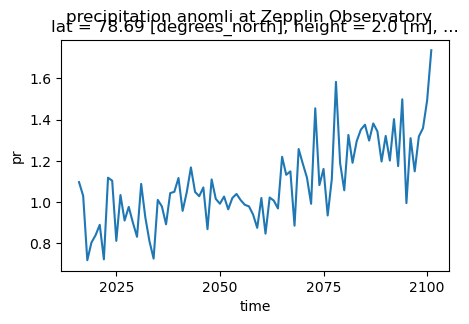

In [46]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
pr_zeppelin_anomali['pr'].plot()
fig.suptitle('precipitation anomli at Zepplin Observatory', fontsize=12)

In [47]:
! pip install pymannkendall

In [48]:

df_NorESM_time = dset['time'].to_dataframe().index.to_datetimeindex()
df_NorESM_time

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/tmp/ipykernel_366/1039237921.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  df_NorESM_time = dset['time'].to_dataframe().index.to_datetimeindex()


DatetimeIndex(['2015-01-16 12:00:00', '2015-02-15 00:00:00',
               '2015-03-16 12:00:00', '2015-04-16 00:00:00',
               '2015-05-16 12:00:00', '2015-06-16 00:00:00',
               '2015-07-16 12:00:00', '2015-08-16 12:00:00',
               '2015-09-16 00:00:00', '2015-10-16 12:00:00',
               ...
               '2100-03-16 12:00:00', '2100-04-16 00:00:00',
               '2100-05-16 12:00:00', '2100-06-16 00:00:00',
               '2100-07-16 12:00:00', '2100-08-16 12:00:00',
               '2100-09-16 00:00:00', '2100-10-16 12:00:00',
               '2100-11-16 00:00:00', '2100-12-16 12:00:00'],
              dtype='datetime64[ns]', length=1032, freq=None)

In [49]:
import pymannkendall as mk
mk.original_test(df_NorESM_time)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=48.105460512149676, Tau=1.0, s=531996.0, var_s=122299969.33333333, slope=2629800000000000.0, intercept=1.4214069e+18)

In [84]:
# function to remove dimensions with only one value
def remove_singledim(ds):
    for dim in ds.dims:
        if len(ds[dim]) == 1:
            ds = ds.squeeze(dim)
    return ds

In [91]:
#NorESM_yearly.squeeze('member_id')

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, time: 86)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    height     float64 2.0
    lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 ... 358.1 358.1 359.4
    member_id  <U8 'r1i1p1f1'
  * time       (time) object 2015-12-31 00:00:00 ... 2100-12-31 00:00:00
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float64 0.2018 0.2018 0.2018 ... 0.9592 0.9593
    prc        (time, lat, lon) float64 0.0 0.0 0.0 ... 0.01396 0.01395 0.01396
    tas        (time, lat, lon) float64 1.965e+07 1.965e+07 ... 2.308e+07

In [101]:
NorESM_yearly = remove_singledim(NorESM_yearly)
#NorESM_yearly['pr']

In [99]:

NorESM_yearly['pr'].shape[0:]


(1, 86, 192, 288)

In [103]:
def trend(ds, variable, season):
    # create a dataset with the trend, intercept and p-value for each grid point
    trend = xr.DataArray(np.zeros(ds[variable].shape[1:]), dims=['lat', 'lon'])
    intercept = xr.DataArray(np.zeros(ds[variable].shape[1:]), dims=['lat', 'lon'])
    p_val = xr.DataArray(np.zeros(ds[variable].shape[1:]), dims=['lat', 'lon'])
    for ilat in range(ds[variable].shape[1]):
        for ilon in range(ds[variable].shape[2]):
            ts = ds[variable][:, ilat, ilon]
            results = mk.original_test(ts)
            trend[ilat, ilon] = results[7]
            intercept[ilat, ilon] = results[8]
            p_val[ilat, ilon] = results[2]
    # trend intercept and p-value are stored in the same dataset
    ds_trend = xr.Dataset({'trend': trend, 'intercept': intercept, 'p_val': p_val})
    return trend, intercept, p_val

pr_trend_NorESM_yearly = trend(NorESM_yearly, 'pr', 'JJA')

In [104]:
pr_trend_NorESM_yearly

(<xarray.DataArray (lat: 192, lon: 288)>
 array([[0.00049423, 0.00049434, 0.00049421, ..., 0.00049422, 0.00049434,
         0.00049422],
        [0.00052212, 0.00052129, 0.00052226, ..., 0.00051813, 0.00051431,
         0.00051662],
        [0.00053101, 0.00052794, 0.00053572, ..., 0.00054771, 0.00053952,
         0.00053251],
        ...,
        [0.00268114, 0.00270692, 0.00272091, ..., 0.00273254, 0.00270113,
         0.00269419],
        [0.00302323, 0.00299871, 0.00300698, ..., 0.00302564, 0.00306117,
         0.00303859],
        [0.00267282, 0.002672  , 0.00267335, ..., 0.0026719 , 0.00267735,
         0.00267467]])
 Dimensions without coordinates: lat, lon,
 <xarray.DataArray (lat: 192, lon: 288)>
 array([[0.21965536, 0.21965138, 0.21965604, ..., 0.21965714, 0.21965142,
         0.21965727],
        [0.19662714, 0.19596697, 0.19537861, ..., 0.19911259, 0.19853351,
         0.19770441],
        [0.16219541, 0.16186702, 0.16101962, ..., 0.16339664, 0.1629321 ,
         0.16267879